In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numba

from typing import Dict

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *
from saturation.plotting import *

In [13]:
def plot_statistics(stats: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot crater count
    ax = axes[0][0]
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_min)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_25_percentile)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_mean)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_75_percentile)
    ax.plot(stats.n_craters_generated, stats.n_craters_in_observation_area_max)
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Observable Craters')

    # Plot crater count
    ax = axes[0][1]
    ax.plot(stats.n_craters_generated, stats.areal_density_min)
    ax.plot(stats.n_craters_generated, stats.areal_density_25_percentile)
    ax.plot(stats.n_craters_generated, stats.areal_density_mean)
    ax.plot(stats.n_craters_generated, stats.areal_density_75_percentile)
    ax.plot(stats.n_craters_generated, stats.areal_density_max)
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes[1][0]
    ax.plot(stats.n_craters_generated, stats.z_min)
    ax.plot(stats.n_craters_generated, stats.z_25_percentile)
    ax.plot(stats.n_craters_generated, stats.z_mean)
    ax.plot(stats.n_craters_generated, stats.z_75_percentile)
    ax.plot(stats.n_craters_generated, stats.z_max)
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes[1][1]
    ax.plot(stats.n_craters_generated, stats.za_min)
    ax.plot(stats.n_craters_generated, stats.za_25_percentile)
    ax.plot(stats.n_craters_generated, stats.za_mean)
    ax.plot(stats.n_craters_generated, stats.za_75_percentile)
    ax.plot(stats.n_craters_generated, stats.za_max)
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.show()


In [14]:
def percentile(n):
    @numba.jit(forceobj=True, fastmath=True)
    def _percentile(x):
        return np.percentile(x, n)
    return _percentile

In [47]:
base_path = '/home/mason/output/'
filenames = [
    # f'{base_path}/sim_run_1_3_0.4_1.5_{x}.txt'
    # for x in range(35)
    f'{base_path}/sim_run_2_9_0.4_1.5_{x}.txt'
    for x in range(28)
]

sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename)
    stats['simulation_id'] = index
    sim_stats.append(stats)

stats = pd.concat(sim_stats, axis=0).dropna()

In [48]:
columns_to_aggregate = [
    'n_craters_in_observation_area',
    'areal_density',
    'z',
    'za'
]
aggregations = {
    x: [
        'min',
        pd.NamedAgg(column=x, aggfunc=percentile(25)),
        'mean',
        pd.NamedAgg(column=x, aggfunc=percentile(75)),
        'max'
    ]
    for x in columns_to_aggregate
}
col_names = [
    [
        f'{x}_min',
        f'{x}_25_percentile',
        f'{x}_mean',
        f'{x}_75_percentile',
        f'{x}_max',
    ]
    for x in columns_to_aggregate
]
col_names = [y for x in col_names for y in x]

grouped = stats.groupby(['n_craters_generated']).agg(
    aggregations
)

grouped.columns = col_names
grouped.reset_index(inplace=True)

In [49]:
grouped.tail()

,n_craters_generated,n_craters_in_observation_area_min,n_craters_in_observation_area_25_percentile,n_craters_in_observation_area_mean,n_craters_in_observation_area_75_percentile,n_craters_in_observation_area_max,areal_density_min,areal_density_25_percentile,areal_density_mean,areal_density_75_percentile,...,z_min,z_25_percentile,z_mean,z_75_percentile,z_max,za_min,za_25_percentile,za_mean,za_75_percentile,za_max
4994,4996,1688,2115.00,2252.357143,2377.25,2756,0.209345,0.261007,0.293172,0.323176,...,0.283763,4.424301,5.110754,5.736936,9.515704,12.276991,20.845450,23.467214,27.189152,35.216361
4995,4997,1688,2115.25,2252.714286,2378.00,2757,0.209388,0.261028,0.293203,0.323167,...,0.264590,4.427533,5.122342,5.757726,9.500908,12.251664,20.845248,23.483790,27.217771,35.204266
4996,4998,1688,2116.00,2253.250000,2378.00,2758,0.209410,0.261052,0.293232,0.323169,...,0.283326,4.436779,5.125466,5.748866,9.459178,12.271883,20.899567,23.491945,27.229838,35.157038
4997,4999,1689,2116.25,2253.892857,2378.00,2758,0.209436,0.261064,0.293244,0.323186,...,0.286609,4.410779,5.114619,5.754013,9.446598,12.281713,20.923162,23.482919,27.261682,35.139403
4998,5000,1690,2117.25,2254.250000,2377.50,2759,0.209457,0.261182,0.293153,0.323341,...,0.231327,4.422516,5.101373,5.709794,9.478162,12.222884,20.873421,23.462470,27.232388,35.188811


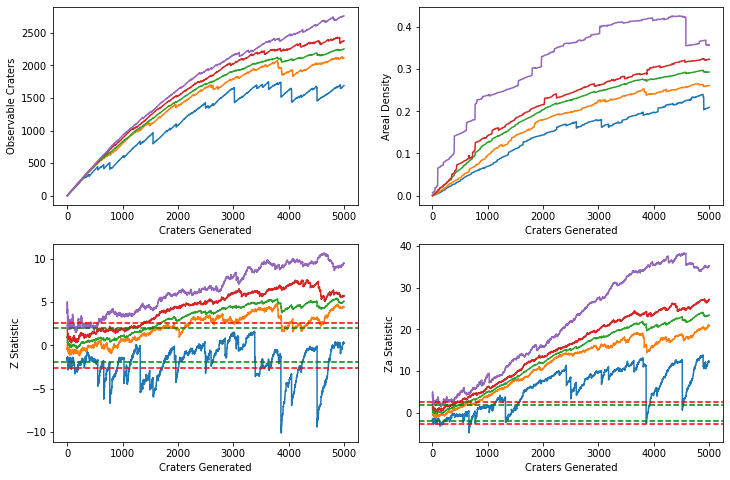

In [50]:
plot_statistics(grouped)

In [51]:
base_path = '/home/mason/code/kirchoff_saturation/output/'
filenames = [
    # f'{base_path}/run_-1.00_1.50_0.40_3.00_{x}_1.csv'
    # for x in range(1, 55)
    f'{base_path}/run_-2.00_1.50_0.40_9.00_{x}_1.csv'
    for x in range(1, 15)
]

sim_stats = []
for index, filename in enumerate(filenames):
    stats = pd.read_csv(filename, skiprows=1)
    stats.columns = ['n_craters_generated', 'n_craters_in_observation_area', 'areal_density', 'z', 'za']
    stats.areal_density = stats.areal_density / 10000**2
    stats['simulation_id'] = index
    sim_stats.append(stats)

stats = pd.concat(sim_stats, axis=0).dropna()

In [52]:
columns_to_aggregate = [
    'n_craters_in_observation_area',
    'areal_density',
    'z',
    'za'
]
aggregations = {
    x: [
        'min',
        pd.NamedAgg(column=x, aggfunc=percentile(25)),
        'mean',
        pd.NamedAgg(column=x, aggfunc=percentile(75)),
        'max'
    ]
    for x in columns_to_aggregate
}
col_names = [
    [
        f'{x}_min',
        f'{x}_25_percentile',
        f'{x}_mean',
        f'{x}_75_percentile',
        f'{x}_max',
    ]
    for x in columns_to_aggregate
]
col_names = [y for x in col_names for y in x]

grouped = stats.groupby(['n_craters_generated']).agg(
    aggregations
)

grouped.columns = col_names
grouped.reset_index(inplace=True)

In [53]:
grouped.tail()

,n_craters_generated,n_craters_in_observation_area_min,n_craters_in_observation_area_25_percentile,n_craters_in_observation_area_mean,n_craters_in_observation_area_75_percentile,n_craters_in_observation_area_max,areal_density_min,areal_density_25_percentile,areal_density_mean,areal_density_75_percentile,...,z_min,z_25_percentile,z_mean,z_75_percentile,z_max,za_min,za_25_percentile,za_mean,za_75_percentile,za_max
4995,4995,1872,2026.75,2206.500000,2368.5,2559,0.263734,0.294403,0.316914,0.338251,...,-1.35,4.0350,4.560714,5.9925,8.63,17.28,22.2375,24.395714,25.7725,33.02
4996,4996,1873,2027.50,2207.142857,2369.0,2560,0.263758,0.294407,0.316912,0.338215,...,-1.15,4.0050,4.566429,5.9800,8.61,17.54,22.2525,24.407143,25.6775,33.01
4997,4997,1874,2028.50,2208.000000,2370.0,2561,0.263787,0.294435,0.316935,0.338262,...,-1.13,3.9975,4.565714,6.0250,8.62,17.56,22.2425,24.412143,25.7125,33.03
4998,4998,1875,2029.25,2208.642857,2371.0,2562,0.264051,0.294457,0.317000,0.338334,...,-1.00,4.0125,4.567143,6.0075,8.63,17.76,22.2275,24.424286,25.7275,33.05
4999,4999,1876,2029.50,2209.142857,2372.0,2561,0.264060,0.294462,0.317043,0.338412,...,-0.98,4.0150,4.577143,6.0125,8.60,17.79,22.2200,24.437857,25.7550,33.02


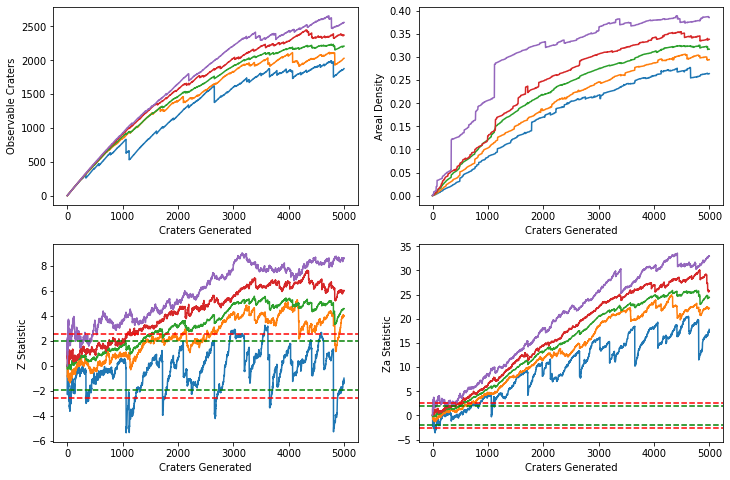

In [54]:
plot_statistics(grouped)